In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
from scipy.signal import lfilter
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.src.callbacks import ReduceLROnPlateau


In [59]:
DATA_TRAIN = "C:\\Users\\s5pen\\YandexDisk\\ВКР\\crowd_train\\raw_crowd_train.tsv"
AUDIO_TRAIN = "C:\\Users\\s5pen\\YandexDisk\\ВКР\\crowd_train\\wavs\\"

DATA_TEST = "C:\\Users\\s5pen\\YandexDisk\\ВКР\\crowd_test\\raw_crowd_test.tsv"
AUDIO_TEST = "C:\\Users\\s5pen\\YandexDisk\\ВКР\\crowd_test\\wavs\\"


data_train = pd.read_csv(DATA_TRAIN, delimiter='\t')
data_train.tail()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
906948,dc1e379757b50ea57ba0d86fa2cfbc2e,wavs/dc1e379757b50ea57ba0d86fa2cfbc2e.wav,4.159625,sad,2.0,cff125aa5153b7677dd28377337dcd2f,индийские фильмы индийские,sad,037539580d1e28a834912088be1b81b0
906949,d923edeb05adcebc215d9ae9d9655a0a,wavs/d923edeb05adcebc215d9ae9d9655a0a.wav,3.784438,neutral,2.0,cff125aa5153b7677dd28377337dcd2f,сериал метро,sad,795e545977414fa4f915249f451d24f8
906950,b5dd4c4fd8f9e1f6f2b77041e0a69fe4,wavs/b5dd4c4fd8f9e1f6f2b77041e0a69fe4.wav,2.722938,neutral,2.0,6a059476b07f0467b9474fc47537784e,смотреть ужасы про крыс,sad,49fe520fd45da95b7c575e3db07846d2
906951,593277832bed252bf5f321223d5d08f4,wavs/593277832bed252bf5f321223d5d08f4.wav,3.349000,neutral,NaN,6a059476b07f0467b9474fc47537784e,мороженщик в реальной жизни,neutral,4de2287e6b082e4f652050eba71d21b2
906952,875a934947d3212d76afe782c4e2ca09,wavs/875a934947d3212d76afe782c4e2ca09.wav,3.320000,angry,4.0,6a059476b07f0467b9474fc47537784e,NaN,NaN,NaN


In [50]:
def create_countplot(data):
    plt.title('Count of emotions for train ', size=16)
    sns.countplot(x='annotator_emo', data=data)
    plt.ylabel('Count', size=12)
    plt.xlabel('Emotions', size=12)
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.show()

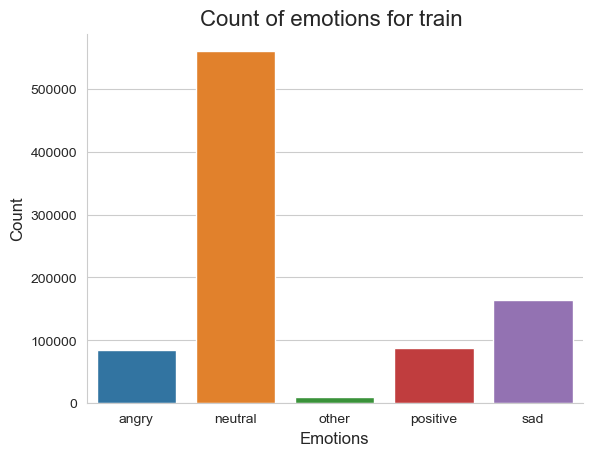

In [51]:
create_countplot(data_train)

In [52]:
data_test = pd.read_csv(DATA_TEST, delimiter='\t')
data_test.head()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,9e9961c53ca6eeb440b217e539fbf46c,wavs/9e9961c53ca6eeb440b217e539fbf46c.wav,5.82,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,я слушаю,neutral,4282ddc30d71ef420e202e0c60391e9f
1,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f
2,d49a6b560155831725a7bdc7d0a96099,wavs/d49a6b560155831725a7bdc7d0a96099.wav,4.38,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,где родился шерлок холмс,neutral,0ee35d2abecf4272ecc8e1539b0839d8
3,c6852b0925797612d7b6724da8cbe7b4,wavs/c6852b0925797612d7b6724da8cbe7b4.wav,8.58,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,открой в браузере ennio morricone,neutral,0855e363c1787df1592f58f7a27ebe13
4,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,a5562e26cd8f1949488a2d1e1e549d97,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f


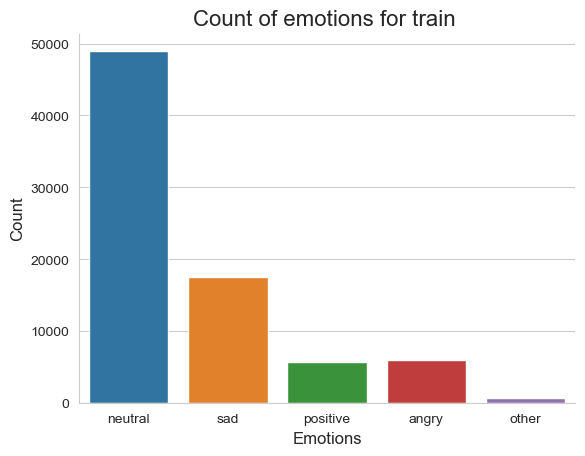

In [60]:
create_countplot(data_test)

In [64]:
def create_tsv_file_for_N_records(value: int):
    # Равное количество записей для каждой эмоции
    emotions = ['angry', 'neutral', 'sad', 'positive']
    records_per_emotion = value // len(emotions)

    # Пустой DataFrame для хранения выбранных записей
    selected_data = pd.DataFrame(columns=data_train.columns)

    # Выбор равного количества записей для каждой эмоции
    for emo in emotions:
        emo_data = data_train[(data_train['annotator_emo'] == emo) & (data_train['speaker_emo'] == emo)].head(records_per_emotion)
        selected_data = pd.concat([selected_data, emo_data])

    # Путь для сохранения нового файла
    raw_crowd_train = f"C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_{value}.tsv"

    # Сохранение выбранных данных в новом TSV файле
    selected_data.to_csv(raw_crowd_train, sep='\t', index=False)


In [62]:
create_tsv_file_for_N_records(4)

In [60]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, emotion):
    # Преобразование аудиоданных в краткосрочное преобразование Фурье (STFT)
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()
    
def create_audio_display(data):
    display(Audio(data))

def create_mfcc_plot(data, sr, emotion):
    # Извлечение признаков MFCC
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)

    # Визуализация графика MFCC
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC for audio with {} emotion'.format(emotion), size=15)
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.tight_layout()
    plt.show()

def create_zcr_plot(data, sr, emotion):
    # Извлечение признаков Zero Crossing Rate (ZCR)
    zcr = librosa.feature.zero_crossing_rate(y=data)

    # Визуализация графика ZCR
    plt.figure(figsize=(8, 4))
    plt.plot(zcr[0], color='b')
    plt.title('Zero Crossing Rate for audio with {} emotion'.format(emotion), size=15)
    plt.xlabel('Frame')
    plt.ylabel('ZCR')
    plt.tight_layout()
    plt.show()

def create_lpc_plot(audio_signal,  emotion):
    lpc_coefficients = librosa.lpc(audio_signal, order=5)

    # Формирование коэффициентов фильтра
    filter_coefficients = np.hstack([[0], -1 * lpc_coefficients[1:]])

    # Применение фильтрации LPC к сигналу
    filtered_signal = lfilter(filter_coefficients, [1], audio_signal)

    # Построение графика исходного сигнала и предсказанного сигнала
    plt.figure(figsize=(10, 4))
    plt.plot(audio_signal, label='Исходный сигнал')
    plt.plot(filtered_signal, linestyle='--', label='Предсказанный сигнал')
    plt.title('Коэффициенты линейного предсказания для  {} эмоции'.format(emotion))
    plt.xlabel('Отсчет')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.show()

In [54]:
data_4 = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_4.tsv", delimiter='\t')
data_4

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7
2,fb44b08978c2254dca5c03b3f8b6f951,wavs/fb44b08978c2254dca5c03b3f8b6f951.wav,4.880,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,ну да плохое,sad,037af49d121127532aa7172f71b4ce19
3,ed5a0505897b5fd7fdd36e75e336e746,wavs/ed5a0505897b5fd7fdd36e75e336e746.wav,5.260,positive,NaN,858305a5450b7bd1288ba0053b1cd1c1,анекдот мне расскажешь,positive,a1863537906ea4335372883d6a9261f7


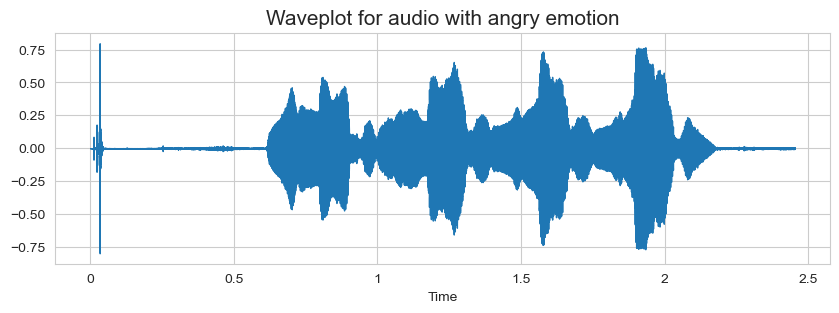

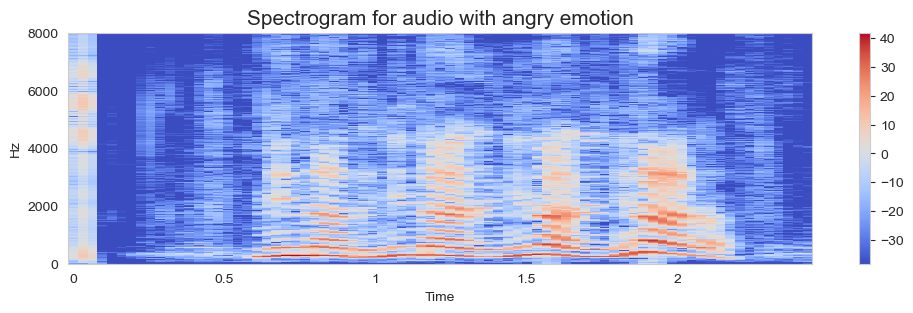

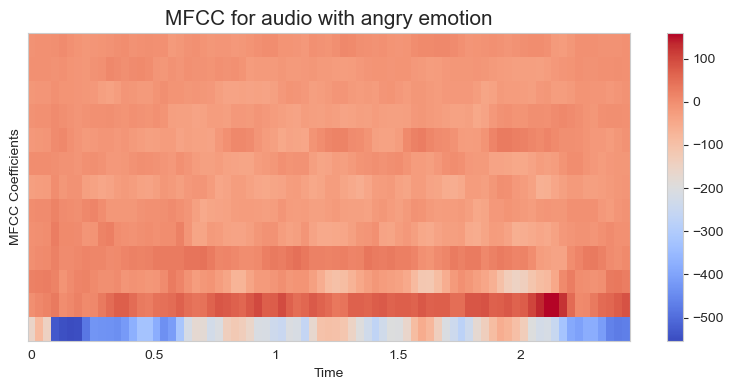

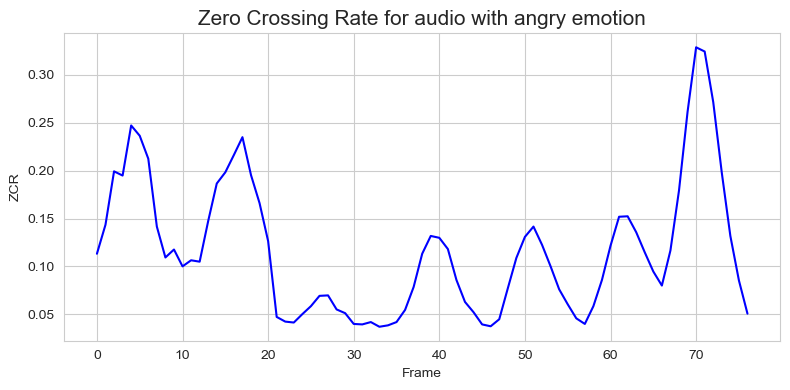

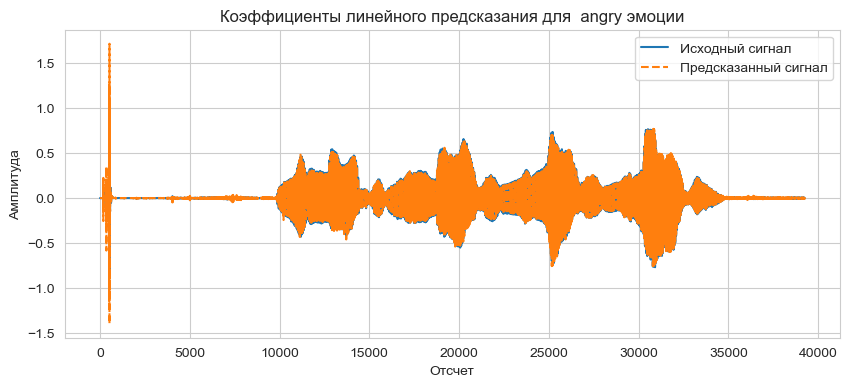

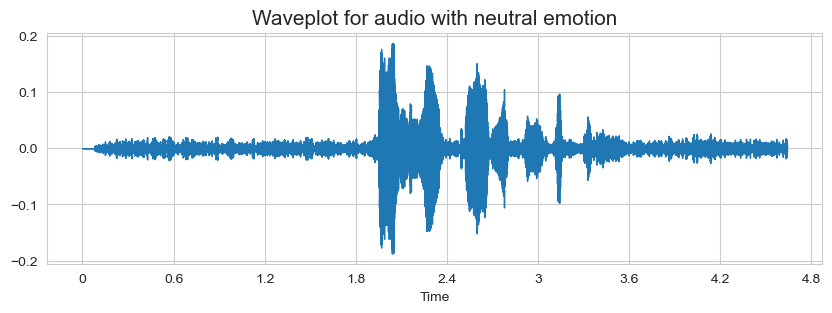

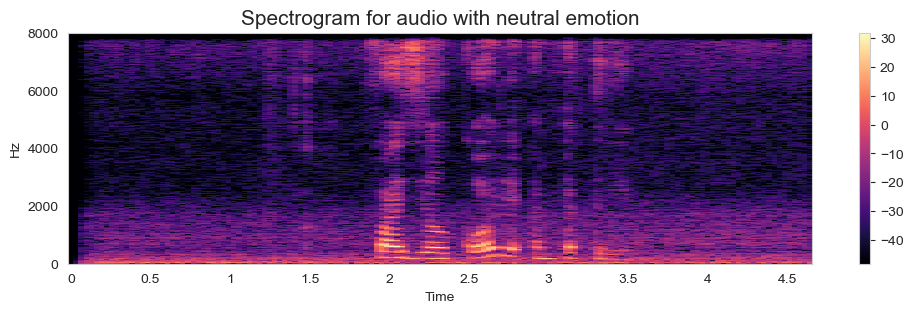

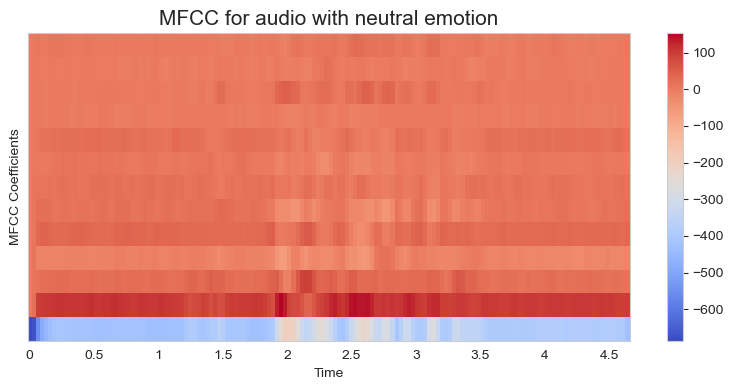

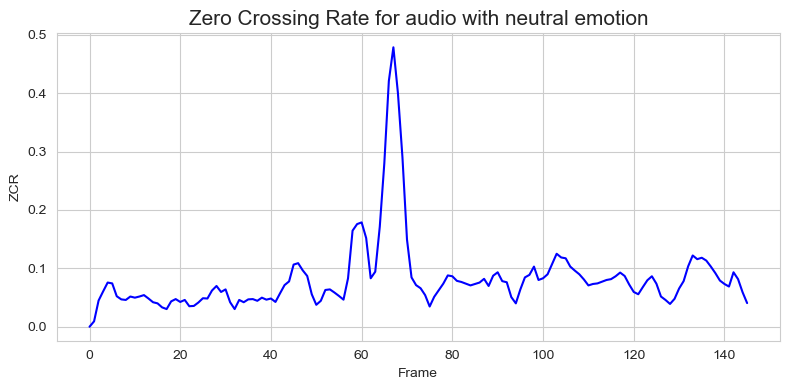

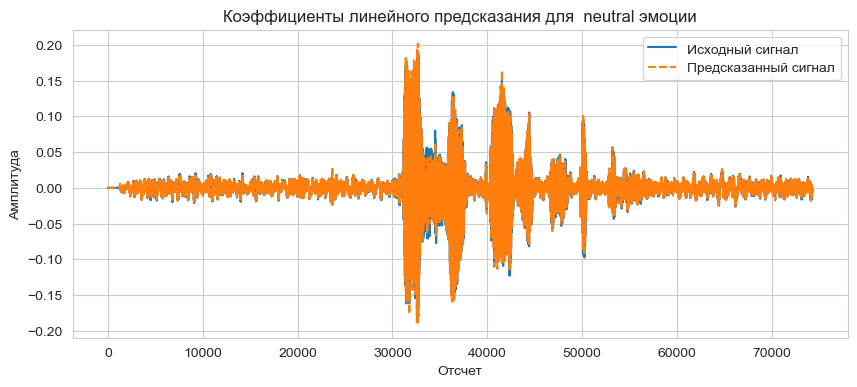

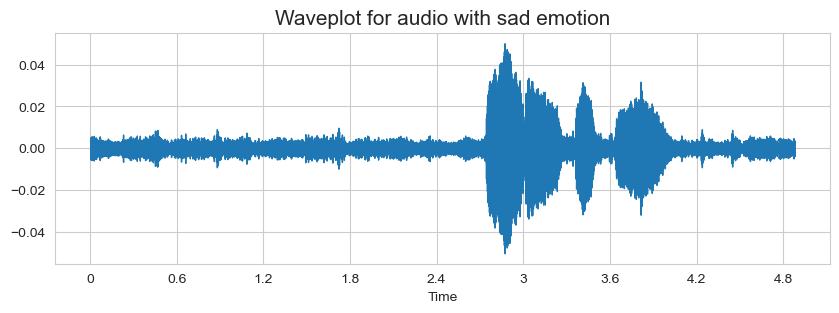

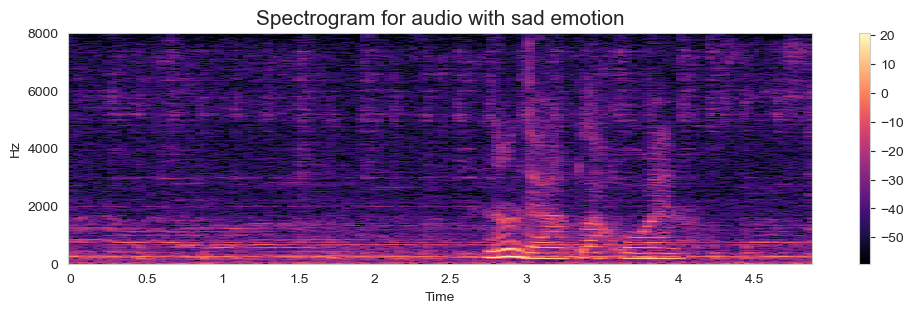

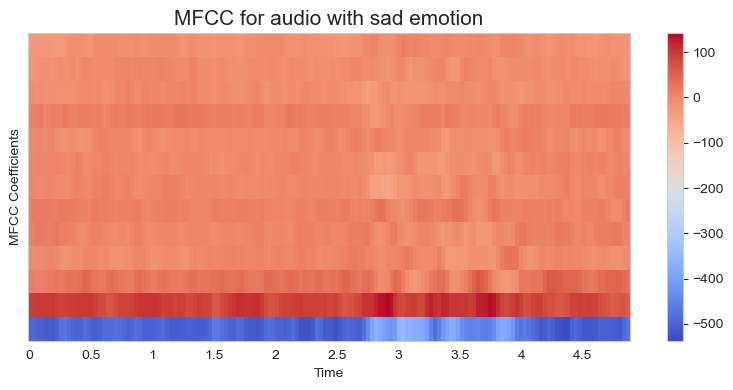

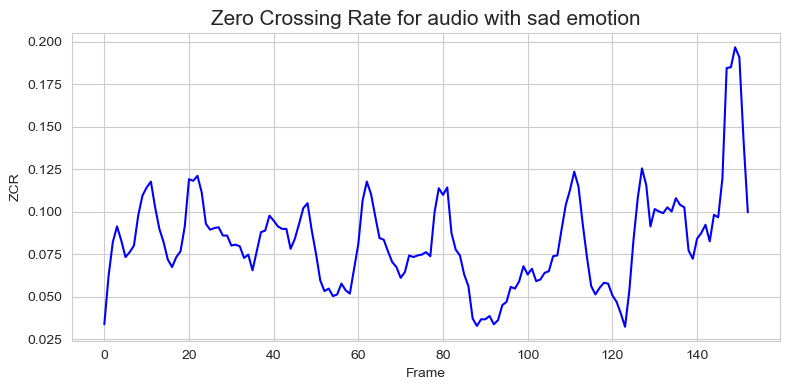

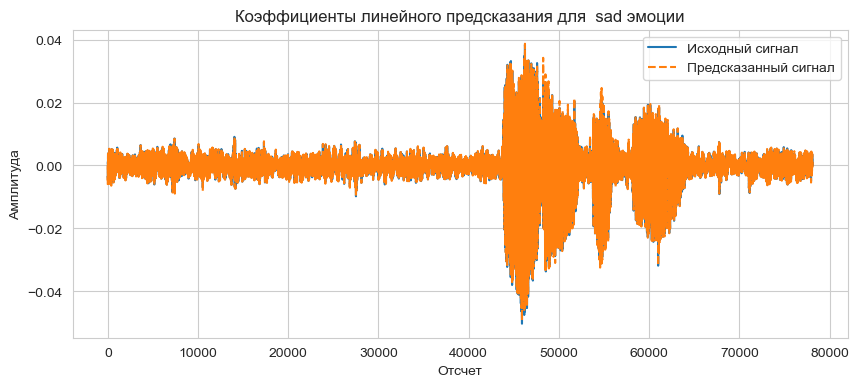

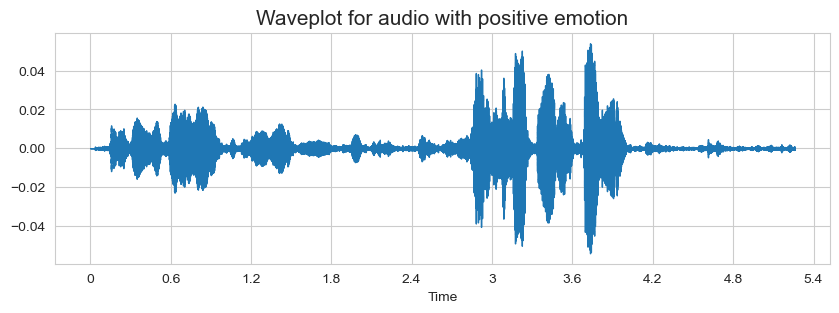

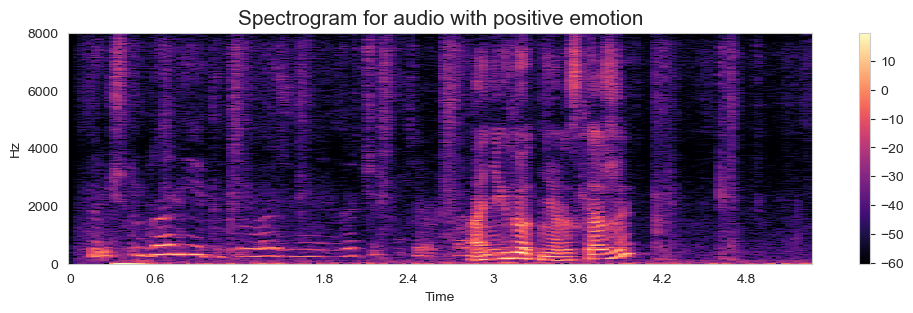

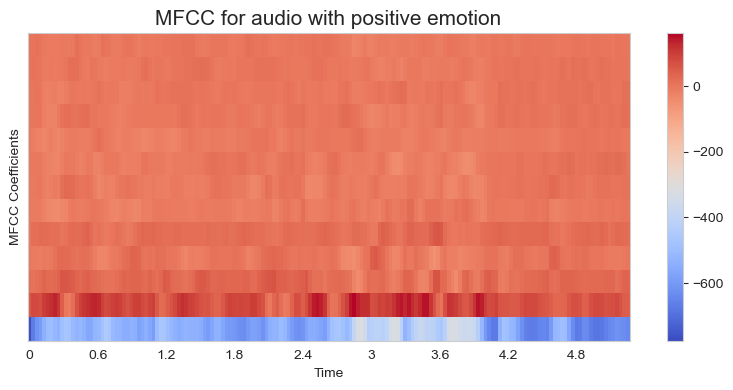

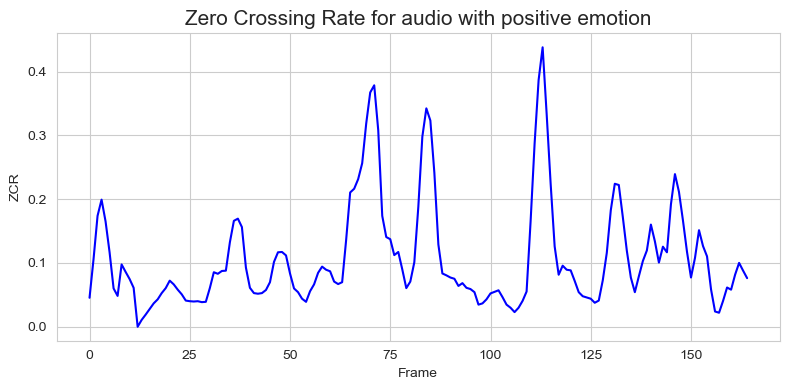

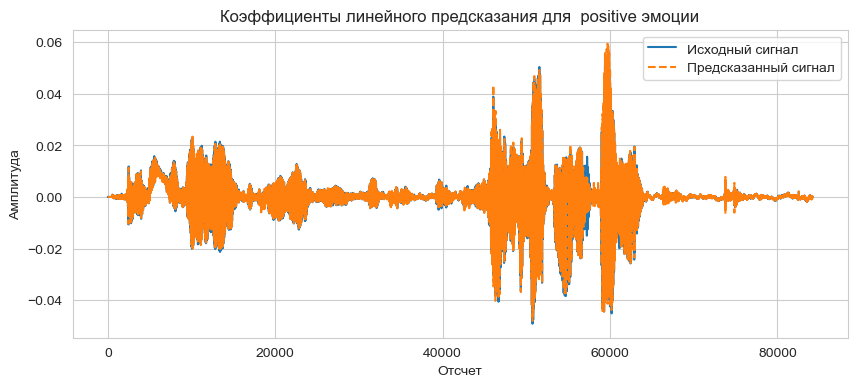

In [56]:
for index, row in data_4.iterrows():
    emotion = row['speaker_emo'] 
    audio_path = AUDIO_TRAIN + row['hash_id'] + ".wav"
    audio_data, sample_rate = librosa.load(audio_path, sr=None)
    create_audio_display(audio_path)
    create_waveplot(audio_data, sample_rate, emotion)
    create_spectrogram(audio_data, sample_rate, emotion)
    create_mfcc_plot(audio_data, sample_rate, emotion)
    create_zcr_plot(audio_data, sample_rate, emotion)
    create_lpc_plot(audio_data, emotion)


# Извлечение признаков

In [63]:
def extract_features(data, sample_rate):
    # signal, sample_rate = librosa.load(path, sr=None)
    result = np.array([])
    
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
    
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    # LPC
    lpc = np.mean(librosa.lpc(data, order=10).T, axis=0)
    result = np.hstack((result, lpc))
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # # data with noise
    # noise_data = noise(data)
    # res2 = extract_features(noise_data)
    # result = np.vstack((result, res2)) # stacking vertically
    # 
    # # data with stretching and pitching
    # new_data = stretch(data)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data_stretch_pitch)
    # result = np.vstack((result, res3)) # stacking vertically
    return result
    

In [46]:
path = AUDIO_TRAIN + "475e76f77ac1ed7cabafca740b15b32a.wav"
aud, sr = librosa.load(path, sr=None)

fearures = get_features(path)
print(fearures)


[-2.60406219e+02  1.11038574e+02 -6.19479141e+01  3.19051247e+01
 -2.49627419e+01 -1.22187510e+01 -2.95872459e+01 -2.35838070e+01
 -1.46854267e+01 -1.01600580e+01 -1.70346718e+01 -2.32411766e+01
 -1.11213045e+01 -1.18840275e+01 -7.16996908e+00 -2.08973579e+01
 -6.44165564e+00 -9.39971256e+00 -1.04084663e+01 -1.85130715e+00
  7.19665527e-02  3.40986578e-03  2.28340854e-03  3.91184818e-03
  4.70318366e-03  3.03959404e-03  9.95162129e-03  1.31307989e-01
  3.00503016e+00  2.80548363e+01  7.28894653e+01  1.29272141e+02
  7.03954926e+01  2.12724953e+01  1.30329714e+01  1.60605583e+01
  2.05414696e+01  3.68440390e+00  5.86535263e+00  9.87966919e+00
  8.25585651e+00  1.37628479e+01  1.97221222e+01  1.42650576e+01
  8.02532673e+00  8.98232079e+00  1.68423576e+01  9.93848419e+00
  7.57999277e+00  8.75479698e+00  1.30191879e+01  2.16753006e+01
  1.61795044e+01  8.90588951e+00  5.03542805e+00  2.76055717e+00
  1.71069837e+00  1.27603936e+00  1.68437004e+00  1.72831762e+00
  7.67370582e-01  7.76680

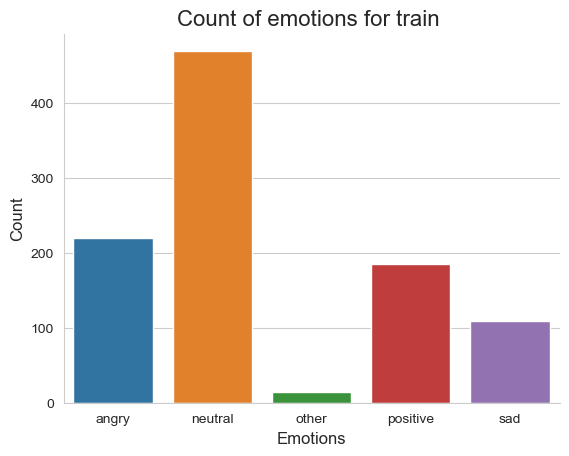

In [17]:

first_1000_rows = data_train.head(1000)

create_countplot(first_1000_rows)

In [43]:
# X, Y = [], []
# audio_path = constants.AUDIO_TRAIN + first_1000_rows.hash_id + ".wav"
# emotions = first_1000_rows.annotator_emo
# 
# for path, emotion in zip(audio_path , emotions):
#     feature = get_features(path)
#     for ele in feature:
#         X.append(ele)
#    #     appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#         Y.append(emotion)

def extract_features_and_labels(audio_path, emotions):
    X, Y = [], []
    for path, emotion in zip(audio_path, emotions):
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            Y.append(emotion)
    return X, Y

KeyboardInterrupt: 

In [ ]:
len(X), len(Y), audio_path.shape

In [31]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv(f'C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\features_{first_1000_rows}.csv', index=False)
Features.head()


,0,labels
0,-260.406219,angry
1,111.038574,angry
2,-61.947914,angry
3,31.905125,angry
4,-24.962742,angry


In [67]:
#Второй набор

first_10_000_rows = data_train.head(10000)
# create_countplot(first_10_000_rows)

X, Y = [], []
audio_path = AUDIO_TRAIN + first_10_000_rows.hash_id + ".wav"
emotions = first_10_000_rows.annotator_emo

for path, emotion in zip(audio_path , emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\features_10000.csv', index=False)
Features.head()

KeyboardInterrupt: 

In [ ]:
create_countplot(first_10_000_rows)


### Подготовка данных

In [68]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [69]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [70]:
from sklearn.model_selection import train_test_split

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1117500, 1), (1117500, 5), (372500, 1), (372500, 5))

In [71]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1117500, 1), (1117500, 5), (372500, 1), (372500, 5))

In [72]:

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=5, activation='softmax')) # unites - количество эмоций для обучения
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 1, 256)            1536      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 1, 256)            0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 1, 256)            327936    
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 1, 256)            0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 1, 128)            163968    
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 1, 128)           

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/10
17461/17461 [==============================] - 427s 24ms/step - loss: 1.2897 - accuracy: 0.4882 - val_loss: 1.2843 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 2/10
17461/17461 [==============================] - 454s 26ms/step - loss: 1.2869 - accuracy: 0.4882 - val_loss: 1.2840 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 3/10
17461/17461 [==============================] - 502s 29ms/step - loss: 1.2867 - accuracy: 0.4882 - val_loss: 1.2840 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 4/10
17461/17461 [==============================] - 522s 30ms/step - loss: 1.2866 - accuracy: 0.4882 - val_loss: 1.2840 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 5/10
17461/17461 [==============================] - 539s 31ms/step - loss: 1.2866 - accuracy: 0.4882 - val_loss: 1.2840 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 6/10
17461/17461 [==============================] - 469s 27ms/step - loss: 1.2866 - accuracy: 0.4882 - val_loss: 1.2840 - val_accuracy: 0.4886 - lr: 4.0000e-04
Epoch 7/10
17461/17461 [

KeyboardInterrupt: 

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(7)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()